<a href="https://colab.research.google.com/github/lydia-r/Data-110/blob/main/DATA_201_PROJECT_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA 201 - PROJECT 3
DECISION TREE

GROUP MEMBERS

LYDIA

STEVE


For this project, I analyzed the Crash Reporting Drivers Data dataset, which contains thousands of records describing drivers involved in traffic crashes.

Each row represents a driver in a crash, and the dataset includes information such as weather conditions, lighting, road surface, collision type, speed limit, vehicle year, and whether the driver was at fault.

The main goal of this project was to understand which crash conditions are associated with driver fault and to determine whether we can predict driver fault.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

RANDOM_STATE = 42

# 1) INTRODUCTION (source, content, questions)

DATA_PATH = "/content/Crash_Reporting_-_Drivers_Data_20251214.csv"


# Questions we can explore:
# Q1: Under what conditions (weather/light/surface) is "Driver At Fault" more common?
# Q2: Do time-of-day and day-of-week correlate with fault outcomes?
# Q3: Which features are most important for predicting "Driver At Fault"?

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nTarget distribution (Driver At Fault):")
print(df["Driver At Fault"].value_counts(dropna=False))

Shape: (207453, 39)
Columns: ['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type', 'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name', 'Off-Road Description', 'Municipality', 'Related Non-Motorist', 'Collision Type', 'Weather', 'Surface Condition', 'Light', 'Traffic Control', 'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault', 'Injury Severity', 'Circumstance', 'Driver Distracted By', 'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent', 'Vehicle First Impact Location', 'Vehicle Body Type', 'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Latitude', 'Longitude', 'Location']

Target distribution (Driver At Fault):
Driver At Fault
Yes        104294
No          98477
Unknown      4682
Name: count, dtype: int64


In [ ]:

# 2) PREPARE + WRANGLE (Pandas / Numpy)

# Parse datetime and create useful time features
df["Crash Date/Time"] = pd.to_datetime(df["Crash Date/Time"], errors="coerce")
df["crash_hour"] = df["Crash Date/Time"].dt.hour
df["crash_dayofweek"] = df["Crash Date/Time"].dt.dayofweek

# Standardize target (keep 3 classes: Yes/No/Unknown), drop missing target rows if any
df = df.dropna(subset=["Driver At Fault"]).copy()

# Optional: reduce rare/noisy categories by filling missing with "Unknown"

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")


/tmp/ipython-input-301303555.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Crash Date/Time"] = pd.to_datetime(df["Crash Date/Time"], errors="coerce")


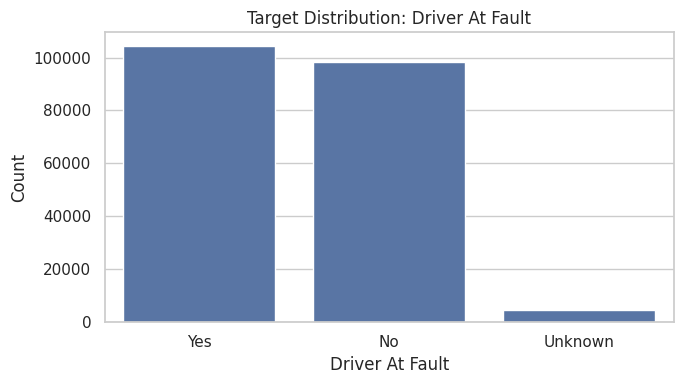

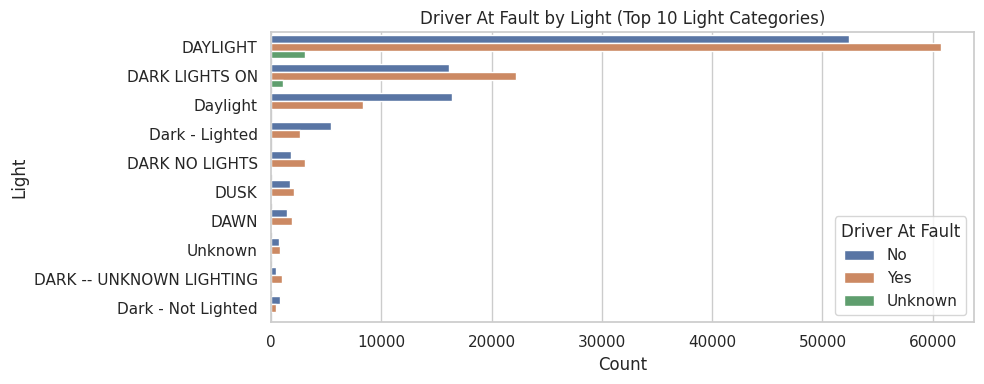

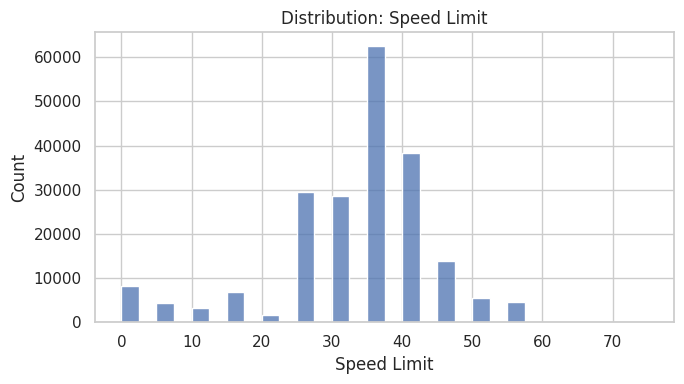

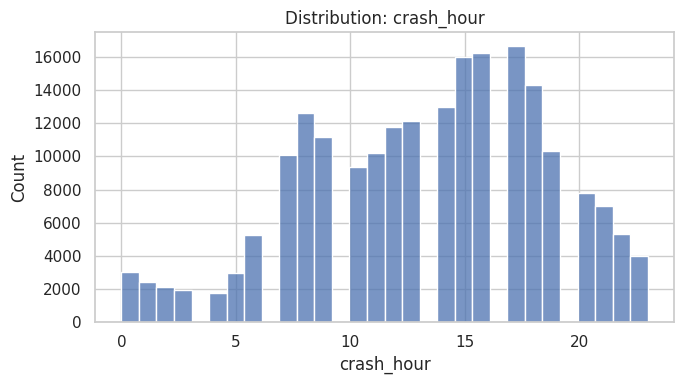

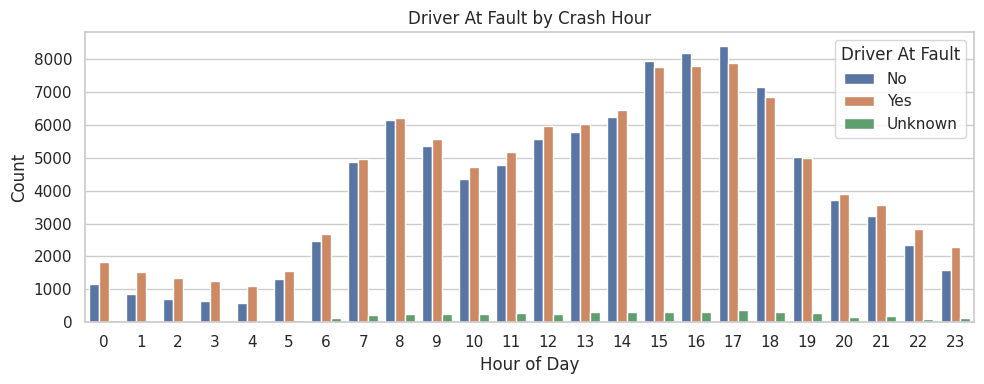

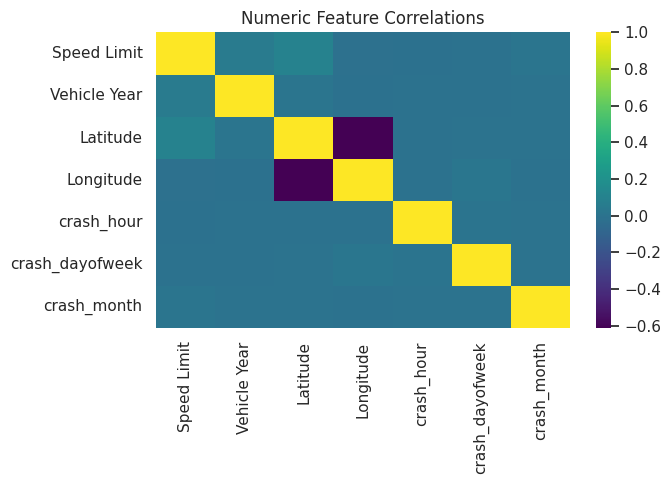

In [ ]:

# 3) EDA VISUALS

sns.set_theme(style="whitegrid")

# A) Target count plot
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="Driver At Fault", order=df["Driver At Fault"].value_counts().index)
plt.title("Target Distribution: Driver At Fault")
plt.xlabel("Driver At Fault")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# C) Fault by Light condition (top 10)
top_light = df["Light"].value_counts().head(10).index
tmp = df[df["Light"].isin(top_light)].copy()
plt.figure(figsize=(10,4))
sns.countplot(data=tmp, y="Light", hue="Driver At Fault", order=top_light)
plt.title("Driver At Fault by Light (Top 10 Light Categories)")
plt.xlabel("Count")
plt.ylabel("Light")
plt.tight_layout()
plt.show()

# D) Numeric distributions
num_cols = ["Speed Limit", "crash_hour"]
for c in num_cols:
    if c in df.columns:
        plt.figure(figsize=(7,4))
        sns.histplot(df[c], bins=30, kde=False)
        plt.title(f"Distribution: {c}")
        plt.tight_layout()
        plt.show()

# E) Crashes by hour and target
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="crash_hour", hue="Driver At Fault")
plt.title("Driver At Fault by Crash Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# F) Correlation heatmap (numeric)
numeric_df = df.select_dtypes(include=[np.number]).copy()
plt.figure(figsize=(7,5))
sns.heatmap(numeric_df.corr(numeric_only=True), annot=False, cmap="viridis")
plt.title("Numeric Feature Correlations")
plt.tight_layout()
plt.show()

In [ ]:

# 4) MODELING: DecisionTreeClassifier


candidate_features = [
    "Collision Type", "Weather", "Surface Condition", "Light", "Traffic Control",
    "Driver Substance Abuse", "Route Type", "Municipality",
    "Speed Limit", "Vehicle Year", "Latitude", "Longitude",
    "crash_hour", "crash_dayofweek", "crash_month"
]

# Keep only features that exist in your file (robustness)
features = [c for c in candidate_features if c in df.columns]
target = "Driver At Fault"

X = df[features].copy()
y = df[target].copy()

# Train/test split (stratify helps keep class proportions similar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Identify categorical and numeric columns for preprocessing
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if X_train[c].dtype != "object"]

# Preprocess:
# - numeric: median impute
# - categorical: most_frequent impute + one-hot
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Decision tree (tune max_depth/min_samples_leaf to reduce overfitting)
tree_clf = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=8,
    min_samples_leaf=50,
    class_weight="balanced"
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("tree", tree_clf)
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Speed Limit',
                                                   'Vehicle Year', 'Latitude',
                                                   'Longitude', 'crash_hour',
                                                   'crash_dayofweek',
                                                   'crash_month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Collision Type', 'Weather',
                                                   'Surface Condition', 'Light',
                                                   'Traffic Control',
                                                   'Driver Substance Abuse',
                                                   'Route Type',
                                                   'Municipality'])])),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=50,
                                        random_state=42))])

In [ ]:

# 5) Predict classes + probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Show a preview of predictions
preview = pd.DataFrame({
    "actual": y_test.iloc[:15].values,
    "predicted": y_pred[:15],
    "prob_severe_injury": y_proba[:15]
})
print("\nPrediction preview (first 15 test rows):")
print(preview)


Prediction preview (first 15 test rows):
   actual predicted  prob_severe_injury
0      No   Unknown            0.451613
1     Yes       Yes            0.396559
2     Yes   Unknown            0.478350
3     Yes       Yes            0.000000
4      No   Unknown            0.451613
5     Yes       Yes            0.000000
6      No   Unknown            0.599355
7      No        No            0.082947
8      No       Yes            0.362304
9      No   Unknown            0.435987
10    Yes   Unknown            0.606605
11     No        No            0.082947
12     No   Unknown            0.451613
13     No       Yes            0.331082
14    Yes       Yes            0.396559



=== Metrics ===
Accuracy:          0.3938
Balanced Accuracy: 0.5366
Macro F1:          0.3398

Classification Report:

              precision    recall  f1-score   support

          No       0.61      0.55      0.58     19696
     Unknown       0.04      0.83      0.08       936
         Yes       0.86      0.23      0.36     20859

    accuracy                           0.39     41491
   macro avg       0.51      0.54      0.34     41491
weighted avg       0.73      0.39      0.46     41491



<Figure size 600x500 with 0 Axes>

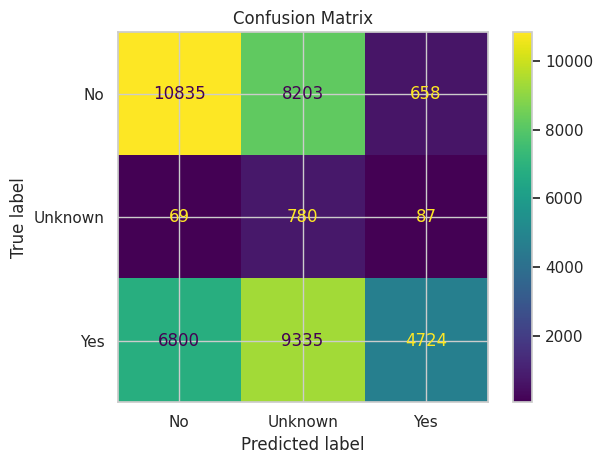

In [ ]:
# 4) METRICS + MEANING

acc = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print("\n=== Metrics ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced Accuracy: {bacc:.4f}")
print(f"Macro F1:          {f1m:.4f}")

# Interpretation:
# - Accuracy: overall correctness.
# - Balanced accuracy: average recall across classes (better when classes are imbalanced).
# - Macro F1: balances precision/recall equally across classes.

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=model.named_steps["tree"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.named_steps["tree"].classes_)
plt.figure(figsize=(6,5))
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

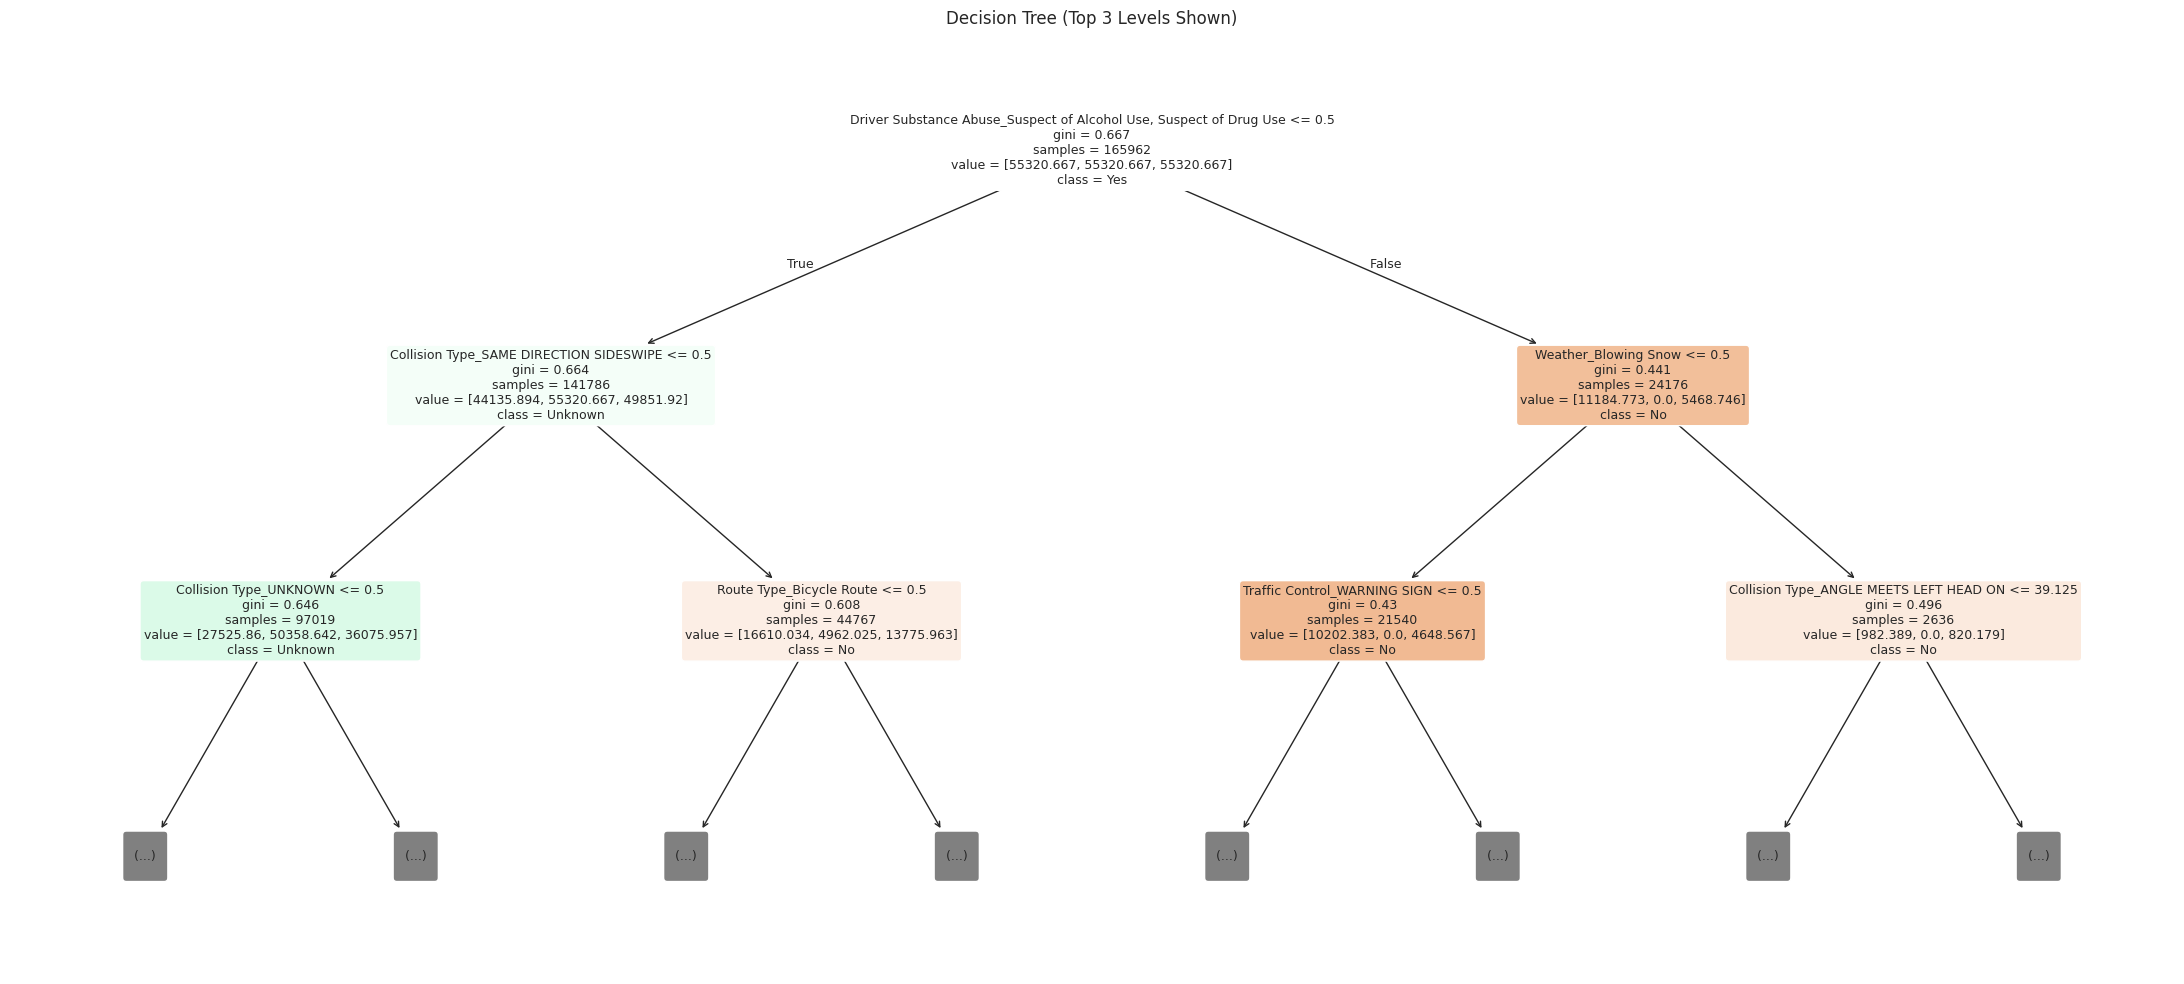

In [ ]:
# 6) PLOT THE TREE

pre = model.named_steps["preprocess"]
tree_est = model.named_steps["tree"]

# Build feature name list
feature_names = []
if len(num_cols) > 0:
    feature_names.extend(num_cols)

if len(cat_cols) > 0:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names.extend(ohe_names)

plt.figure(figsize=(22,10))
plot_tree(
    tree_est,
    feature_names=feature_names,
    class_names=[str(c) for c in tree_est.classes_],
    filled=True,
    rounded=True,
    max_depth=2,
    fontsize=9
)
plt.title("Decision Tree (Top 3 Levels Shown)")
plt.tight_layout()
plt.show()




Top 20 Feature Importances:
Driver Substance Abuse_Not Suspect of Alcohol Use, Not Suspect of Drug Use    0.251070
Collision Type_SAME DIR REAR END                                              0.240765
Driver Substance Abuse_UNKNOWN                                                0.080513
Collision Type_SINGLE VEHICLE                                                 0.080186
Driver Substance Abuse_Unknown, Unknown                                       0.069765
Driver Substance Abuse_ALCOHOL PRESENT                                        0.061070
Traffic Control_TRAFFIC SIGNAL                                                0.038358
Longitude                                                                     0.027628
Collision Type_STRAIGHT MOVEMENT ANGLE                                        0.025900
Latitude                                                                      0.021456
Speed Limit                                                                   0.020893
Vehicle Year  

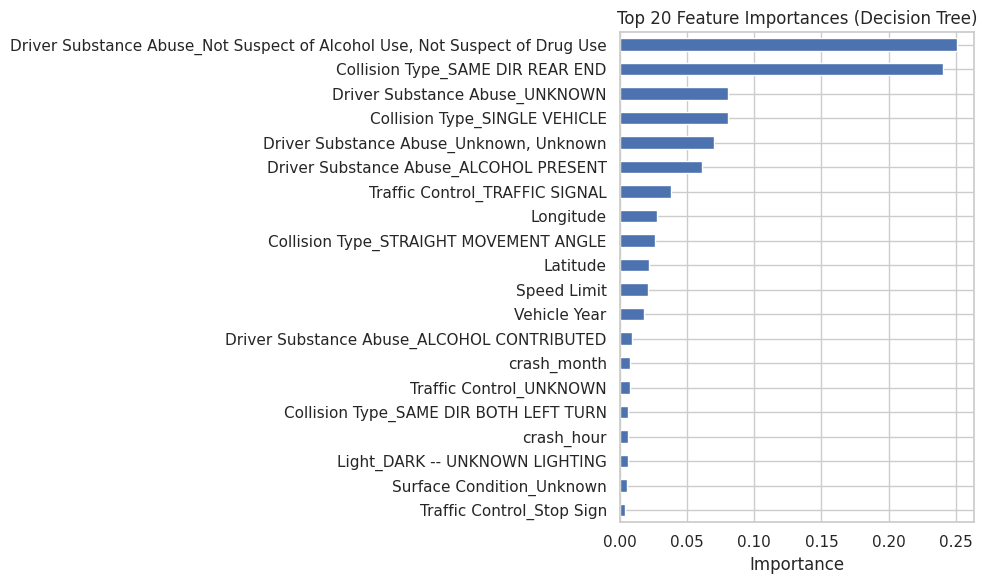

In [ ]:

# 7) INTERPRETATION HELPERS

importances = tree_est.feature_importances_
imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\nTop 20 Feature Importances:")
print(imp.head(20))

plt.figure(figsize=(10,6))
imp.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
